In [1]:
import pandas as pd
import json
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import nltk
from coclust.coclustering import CoclustMod, CoclustSpecMod, CoclustInfo
from tqdm import tqdm_notebook, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import shuffle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import re, string, timeit
from string import digits
from collections import defaultdict
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from PIL import Image

### Step 1 -  list genes / maladies

In [3]:
genes = {}
with open("list_genes.txt") as f:
    for g in tqdm_notebook(f.readlines()):
        genes[g.strip().lower()] = []

maladies = {}
with open("list_maladies.txt") as f:
    for m in tqdm_notebook(f.readlines()):
        maladies[m.strip().lower()] = []

A Jupyter Widget

A Jupyter Widget

In [9]:
list_genes = list(genes.keys())
list_maladies = list(maladies.keys())

In [6]:
#stop_words = set(stopwords.words('english')) 

## Step 2 - index genes / maladies 

In [12]:
idx = 1
with open("asthma.json") as f:
    asthma = f.readlines()
asthma[0] = asthma[0][1:]

In [13]:
stop_words = set(stopwords.words('english'))
stem = nltk.stem.SnowballStemmer('english')
lem = nltk.stem.WordNetLemmatizer()
remove_digits = str.maketrans('', '', digits)

In [14]:
new_asthma = []
for a in tqdm(asthma):
    js = json.loads(a)
    text = js["ab"].lower()

    text_p = text.translate(str.maketrans('', '', string.punctuation))
    text_p = text_p.translate(remove_digits)
    
    word_tokens = word_tokenize(text_p)
    filtered_sentence = [lem.lemmatize(w) for w in word_tokens if not w in stop_words and len(w) > 1 and w not in list_genes]
    text_cleaned = nltk.Text(filtered_sentence)
    
    mds = []
    for m in list_maladies:
        if m in text:
            maladies[m].append(idx)
            mds.append(m)

    gns = []
    for g in list_genes:
        if g in text:
            genes[g].append(idx)
            gns.append(g)
    
    new_js = {
        "id" : idx,
        "text" : text_cleaned[:],
        "maladies" : mds,
        "genes" : gns
    }
    
    new_asthma.append(new_js)
    idx = idx + 1

100%|██████████| 44975/44975 [44:35<00:00, 16.81it/s]


In [15]:
with open('asthma_preprocessed.json', 'w') as outfile:  
    json.dump(new_asthma, outfile)

In [16]:
genes_v2 = {k: v for k, v in genes.items() if v}
maladies_v2 = {k: v for k, v in maladies.items() if v}

In [17]:
del maladies_v2["disease"]

In [42]:
with open('genes_index.json', 'w') as outfile:  
    json.dump(genes_v2, outfile)

In [56]:
with open('maladies_index.json', 'w') as outfile:  
    json.dump(maladies_v2, outfile)

##### create maladies - genes

## Step 3 - Creation matrix genes - genes 

In [3]:
maladiesjson = json.load(open("maladies_index.json"))
genesjson = json.load(open("genes_index.json"))
asthma = json.load(open("asthma_preprocessed.json"))

In [4]:
asthmajson = { str(v["id"]):v for v in asthma }

In [5]:
select_m = shuffle(list(maladiesjson.keys()))
select_g = shuffle(list(genesjson.keys()))

In [7]:
maladiesgenes = defaultdict(list)
for art in tqdm(asthma):    
    for m in art["maladies"]:
        maladiesgenes[m].extend(art["genes"])

100%|██████████| 44975/44975 [00:00<00:00, 403304.50it/s]


In [8]:
maladiesgenes_json = {}
for k,v in tqdm(maladiesgenes.items()):
    maladiesgenes_json[k] = list(set(v))

100%|██████████| 1415/1415 [00:00<00:00, 9417.45it/s]


In [143]:
del maladiesgenes_json["disease"]

In [144]:
with open('maladies_genes.json', 'w') as outfile:  
    json.dump(maladiesgenes_json, outfile)

In [146]:
maladiesgenes = json.load(open("maladies_genes.json"))

###  Select maladie and genes related

In [9]:
m = maladiesjson["myocarditis"]

In [33]:
# selected_genes = ['cd4', 'myoc', 'nnat', 'cic', 'tro', 'amely', 'acr', 'poli', 'sts', 'tg', 'plat', 'caps', 'epor', 'comp', 'erf', 'mpo', 'dap', 'ttl', 'proc', 'spr', 'atic', 'tnfaip3', 'cript', 'cat', 'ung', 'inha', 'nin', 'raly', 'urod', 'idua', 'gan', 'lif', 'epo', 'fus', 'pi4ka', 'nts', 'gns', 'nov', 's', 'hal', 'lyz', 'cit', 'lpo', 'ogn', 'mag', 'ell', 'aspa', 'tyr', 'eed', 'mia', 'osbp', 'tecta', 'si', 'aga', 'cp', 'thra', 'cad', 'scarb2', 'tars', 'por', 'ide', 'lum', 'sord', 'pi4kb', 'ren', 'mall', 'mut', 'nono', 'star', 'adm', 'atm', 'aip', 'pts', 'fer', 'grap', 'impact', 'app', 'ace', 'aire', 'unk', 'rel', 'alpi', 'alb', 'rho', 't', 'scin', 'poll', 'bean', 'emb', 'abr', 'tub', 'aven', 'she', 'tert', 'iscu', 'mal', 'rest', 'mak', 'abo', 'rrh']
selected_genes = ['cd4', 'myoc', 'nnat', 'cic', 'tro', 'amely', 'acr', 'poli', 'sts', 'tg', 'plat', 'caps', 'epor', 'comp', 'erf', 'mpo', 'dap', 'ttl', 'proc', 'spr', 'atic', 'tnfaip3', 'cript', 'cat', 'ung', 'inha', 'nin', 'raly', 'urod', 'idua', 'gan', 'lif', 'epo', 'fus', 'pi4ka', 'nts', 'gns', 'nov', 'hal', 'lyz', 'cit', 'lpo', 'ogn', 'mag', 'ell', 'aspa', 'tyr', 'eed', 'mia', 'osbp', 'tecta', 'si', ]

In [34]:
genes_articles_str = [ ' '.join(str(x) for x in genesjson[g]) for g in selected_genes ]
l = [ genesjson[g] for g in selected_genes ]
genes_articles = list(set([item for sublist in l for item in sublist]))

In [35]:
articles_text = [ ' '.join(asthmajson[str(i)]["text"]) for i in genes_articles ]

## matrix genes - terms

In [108]:
vec = TfidfVectorizer(max_df=0.6, min_df=0.01)
dt = vec.fit_transform(articles_text)

/Users/yannis/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [109]:
df2 = pd.DataFrame(dt.toarray(), columns=vec.get_feature_names())

In [110]:
matrix_article_terms = dt.toarray()
matrix_genes_terms = defaultdict(lambda : np.zeros(matrix_article_terms.shape[1]).astype(np.float64)   )

In [111]:
for idx, row in tqdm(enumerate(matrix_article_terms)):
    article = asthmajson[str(genes_articles[idx])]
    for ge in article["genes"]:
        if ge in selected_genes:
            matrix_genes_terms[ge] +=  row
        #genes_termes.append(dt)
        #genes_list.append(ge)

42679it [00:02, 19657.27it/s]


In [112]:
dt.shape

(42679, 1718)

In [113]:
list_matrix_genes_terms = [ v for k,v in matrix_genes_terms.items() ]
list_genes = [ k for k,v in matrix_genes_terms.items() ]

In [114]:
df3 = pd.DataFrame(list_matrix_genes_terms, columns=vec.get_feature_names())

In [115]:
df3.head()

,ability,able,abnormal,abnormality,absence,access,accompanied,according,account,accumulation,...,world,worldwide,worse,would,year,yearold,yet,young,younger,μm
0,63.661150,40.387433,16.753230,17.727406,33.250769,47.031426,17.855547,48.121249,33.097850,29.404322,...,42.357336,36.948012,12.135497,50.125318,187.662663,17.135919,42.672609,43.827995,21.320970,29.401101
1,23.506478,13.888999,7.922203,12.060465,13.515098,29.437120,5.465693,28.527329,20.085239,6.059542,...,19.317926,16.773696,8.869343,25.980935,134.270742,6.329955,19.829090,28.785148,14.935215,6.619558
2,35.034848,22.190818,11.427759,12.721571,20.245934,22.808510,11.032561,34.795236,19.486893,13.481119,...,24.737937,24.207554,17.963393,30.469832,191.840557,12.370741,22.536611,37.773684,17.780719,9.776043
3,109.537179,73.692635,47.449559,50.755136,67.147683,104.177653,31.025374,134.413896,74.377249,46.472231,...,74.373618,72.287561,42.253009,113.250648,606.040307,44.812291,80.036638,108.003612,62.018308,42.632031
4,164.662706,104.880717,67.846036,69.269656,104.899942,134.526288,56.540772,166.441236,95.592379,86.162498,...,107.831815,102.256394,49.424675,153.357391,754.261594,78.797007,118.080556,145.662712,75.401531,71.485803


In [116]:
df3.shape

(52, 1718)

In [117]:
# df3_norm =  StandardScaler().fit_transform(df3)

In [118]:
# sns.heatmap(df3,cmap="BuPu")
# plt.title("CoclustMod %i clusters"%2)
# plt.show()

In [119]:
dt = np.array(df3)
model = CoclustMod(n_clusters=2, random_state=0)
m1 = model.fit(dt)
fit_data = dt[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

In [48]:
# model.modularity

In [49]:
# sns.heatmap(np.log(dt+1),cmap="BuPu")
# plt.title("CoclustMod %i clusters"%2)
# plt.show()

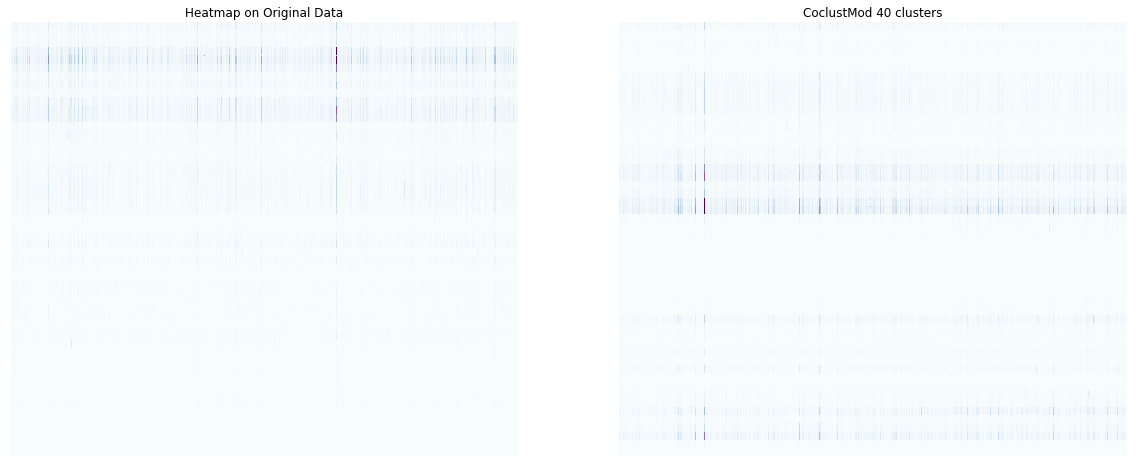

In [50]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sns.heatmap(dt,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("Heatmap on Original Data")

plt.subplot(122)
sns.heatmap(fit_data,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("CoclustMod %i clusters"%40)

plt.show()
#plt.savefig("test.jpg")

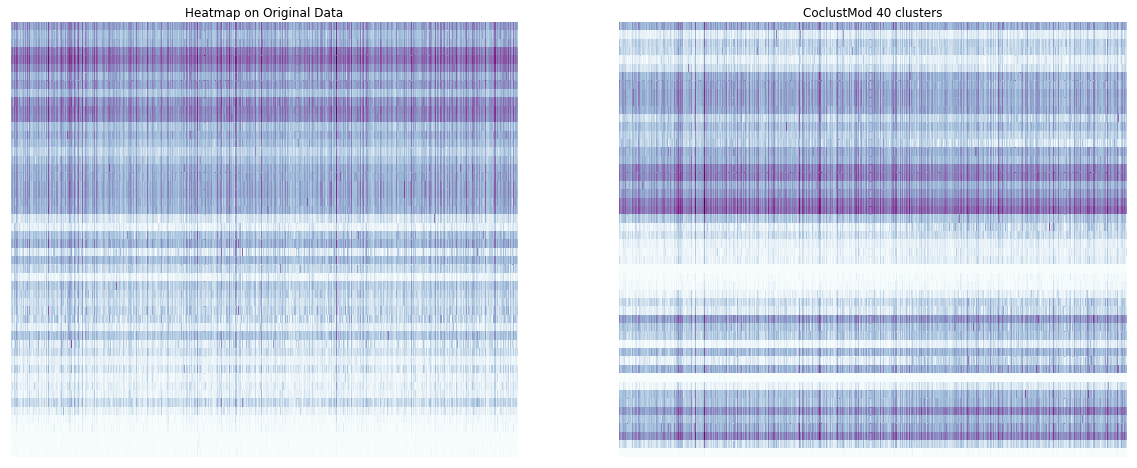

In [51]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sns.heatmap(np.log(dt+1),cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("Heatmap on Original Data")

plt.subplot(122)
sns.heatmap(np.log(fit_data+1),cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("CoclustMod %i clusters"%40)

plt.show()
#plt.savefig("test.jpg")

In [195]:
scaler = StandardScaler()

In [196]:
fit_scale = scaler.fit_transform(fit_data)
dt_scale = scaler.fit_transform(dt)

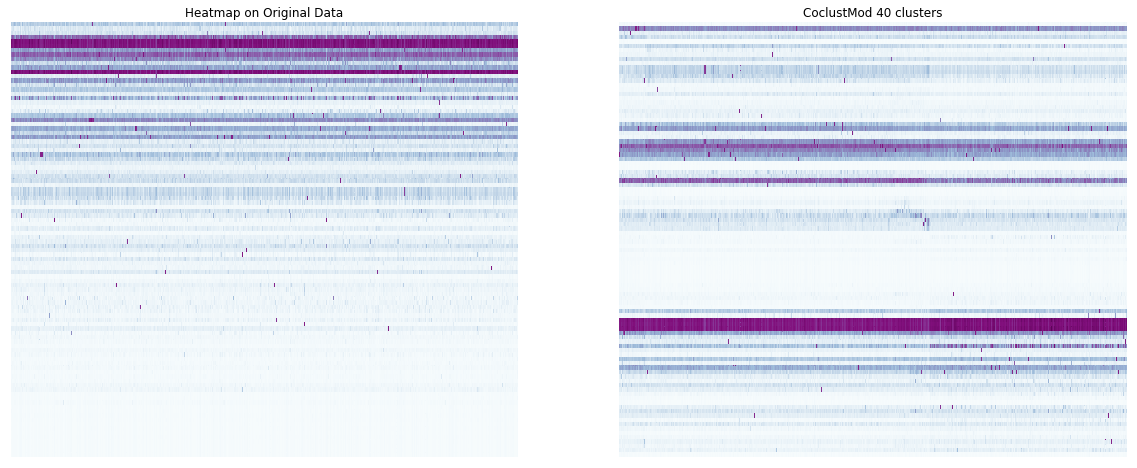

In [197]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sns.heatmap(dt_scale,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("Heatmap on Original Data")

plt.subplot(122)
sns.heatmap(fit_scale,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("CoclustMod %i clusters"%40)

plt.savefig("test.jpg")

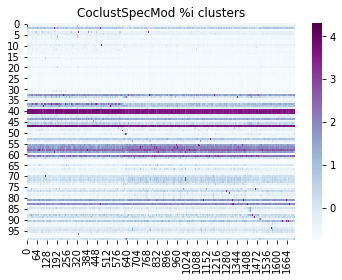

In [108]:
sns.heatmap(okk,cmap="BuPu")
plt.title("CoclustSpecMod %i clusters")
plt.show()

In [202]:
dt = np.array(df3)
model2 = CoclustSpecMod(n_clusters=10, random_state=0)
m2 = model2.fit(dt)
fit_data2 = dt[np.argsort(model2.row_labels_)]
fit_data2 = fit_data2[:, np.argsort(model2.column_labels_)]

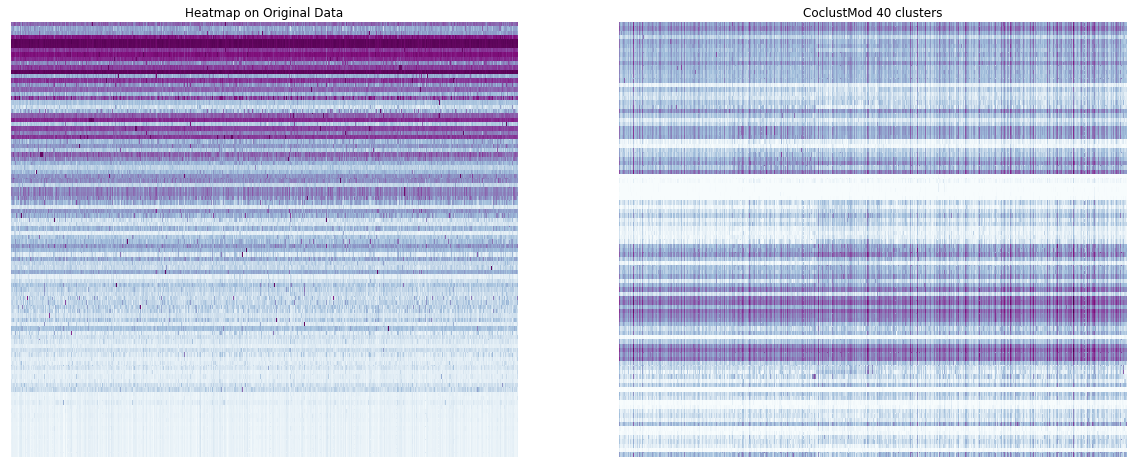

In [203]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sns.heatmap(np.log(dt_scale+1),cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("Heatmap on Original Data")

plt.subplot(122)
sns.heatmap(np.log(fit_data2+1),cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("CoclustMod %i clusters"%40)

plt.show()

In [45]:
dt = np.array(df3)
model3 = CoclustInfo(random_state=0)
m3 = model3.fit(dt)
fit_data3 = dt[np.argsort(model3.row_labels_)]
fit_data3 = fit_data3[:, np.argsort(model3.column_labels_)]

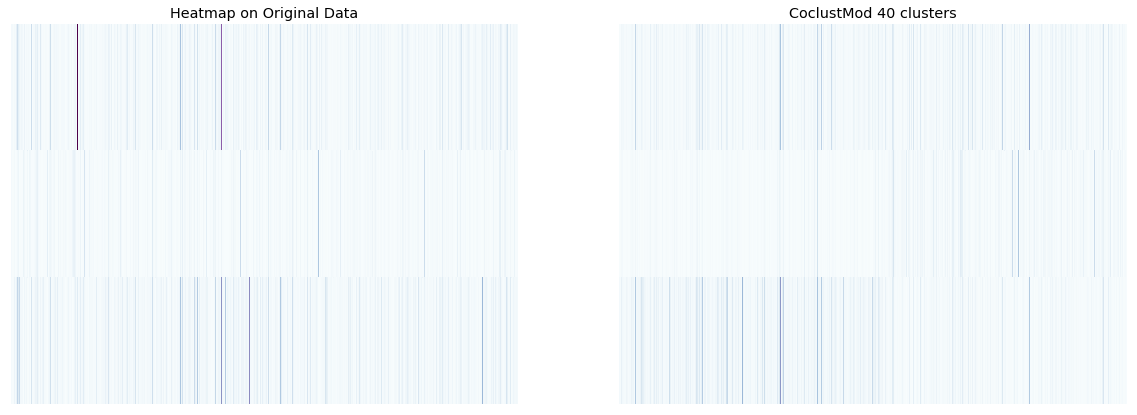

In [59]:
plt.figure(figsize=(20,7))
plt.subplot(121)
sns.heatmap(dt,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("Heatmap on Original Data")

plt.subplot(122)
sns.heatmap(fit_data3 ,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("CoclustMod %i clusters"%40)

plt.show()

In [28]:
clusters_range = range(1, len(df3))
model, modularities = best_modularity_partition(np.array(df3), clusters_range, n_rand_init=1)

Computing coclust modularity for a range of cluster numbers =
 1 ...
 2 ...
 All done !


In [354]:
model.modularity

0.376182511498611

In [60]:
# dt = np.array(df3)
model3 = CoclustInfo(random_state=0)
m3 = model3.fit(df3)
fit_data3 = dt[np.argsort(model3.row_labels_)]
fit_data3 = fit_data3[:, np.argsort(model3.column_labels_)]

In [228]:
Z

array([[  0.        ,   2.        , 201.29275672,   2.        ],
       [  1.        ,   3.        , 269.31930969,   3.        ]])

In [133]:
Z = linkage(dt, 'single', 'euclidean')

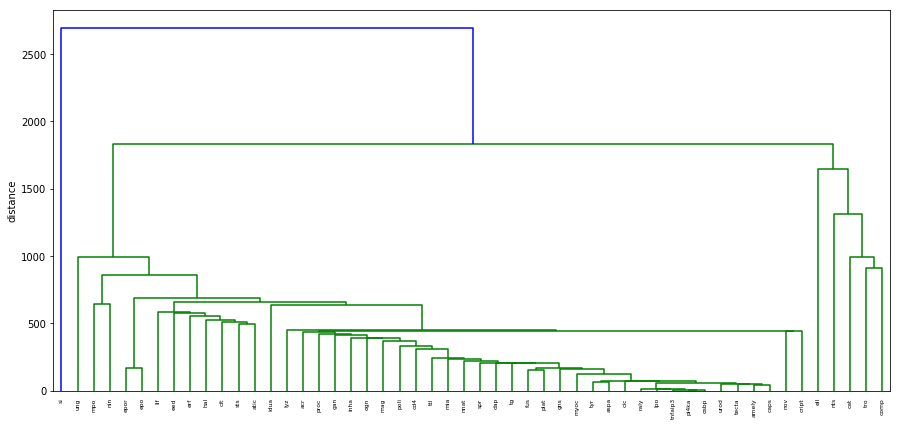

In [134]:
plt.figure(figsize=(15, 7))
plt.xlabel('')
plt.ylabel('distance')
dendrogram(
    Z,
    labels = list_genes
)
plt.show()
#plt.savefig("test3.jpg")

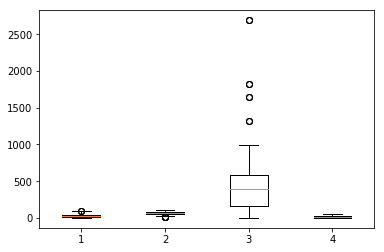

In [61]:
plt.boxplot(Z)
plt.show()

In [62]:
Z.shape

(51, 4)

In [80]:
from scipy.spatial.distance import pdist,cdist, squareform

In [132]:
%%time
yeah = squareform(pdist(dt,"euclidean"))

CPU times: user 4.69 ms, sys: 1.27 ms, total: 5.96 ms
Wall time: 4.08 ms


In [130]:
%%time
pww = cdist(dt,dt,"euclidean")

CPU times: user 8.34 ms, sys: 1.04 ms, total: 9.39 ms
Wall time: 7.9 ms


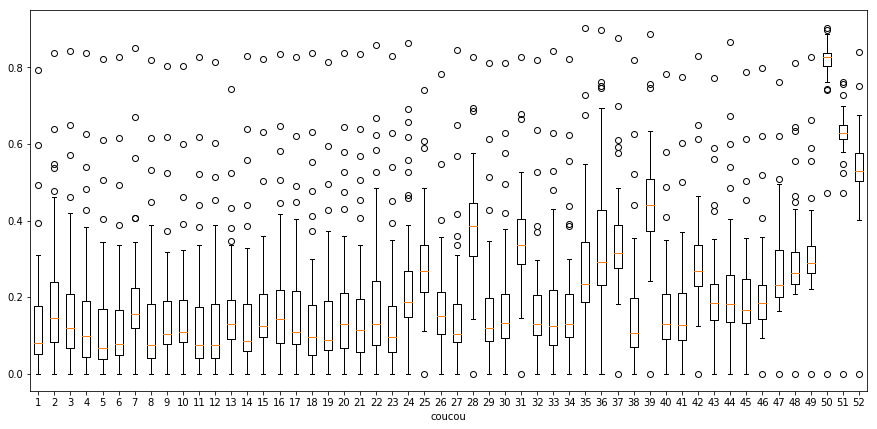

In [96]:
plt.figure(figsize=(15, 7))
plt.boxplot(pww)
plt.xlabel("Genes sets")
plt.show()

In [146]:
def yeah(nb, m):
    p =  (nb/m)*100
    with open("progress.txt", 'w') as filetowrite:
        filetowrite.write(str(int(p)))

In [147]:
yeah(15,30)

## matrix Genes - articles 

In [254]:
vec = CountVectorizer()
X = vec.fit_transform(genes_articles_str)

In [291]:
X.shape

(7, 26051)

In [255]:
# df1 = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [301]:
xn = X.shape[0]
step = round(xn/15) if round(xn/15) > 0 else 1
rng =  range(1, xn, step)

In [351]:
model, modularities = best_modularity_partition(X, rng, n_rand_init=1)

Computing coclust modularity for a range of cluster numbers =
 1 ...
 2 ...
 3 ...
 4 ...
 5 ...
 6 ...
 All done !


In [303]:
nb = rng[np.argmax(modularities)]

In [304]:
nb

6

In [299]:
modularities

[4.887893927746018e-17,
 0.15090454175788667,
 0.3349020175615068,
 0.34380886118047904,
 0.3733164975435577,
 0.376182511498611]

In [261]:
dt = X.toarray()
model = CoclustMod(n_clusters=4, random_state=0)
m1 = model.fit(dt)
fit_data = dt[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

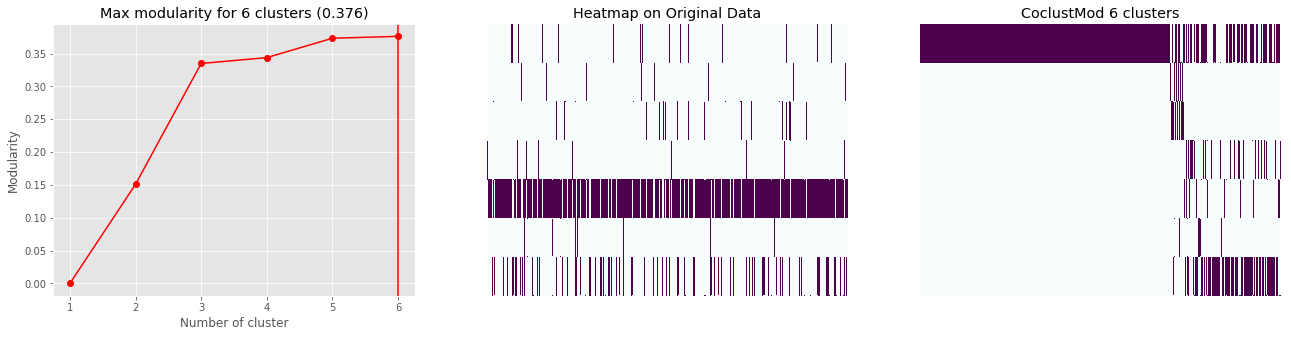

In [353]:
plt.figure(figsize=(22,5))

plt.subplot(131)
plt.plot(rng, modularities, 'ro-')
plt.xlabel("Number of cluster")
plt.ylabel("Modularity")
plt.title("Max modularity for "+str(nb)+" clusters ("+str(round(np.max(modularities),3))+")")
plt.axvline(x=nb, color='r', linestyle='-')


plt.subplot(132)
sns.heatmap(dt,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("Heatmap on Original Data")

plt.subplot(133)
sns.heatmap(fit_data,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("CoclustMod %i clusters"%nb)


plt.savefig("test4.jpg",bbox_inches='tight',  pad_inches = 0)

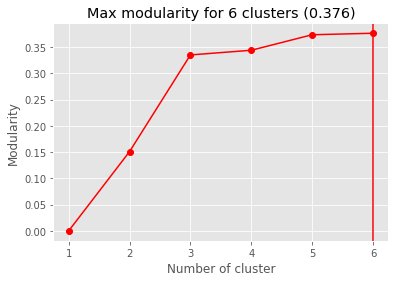

In [338]:
plt.plot(rng, modularities, 'ro-')
plt.xlabel("Number of cluster")
plt.ylabel("Modularity")
plt.title("Max modularity for "+str(nb)+" clusters ("+str(round(np.max(modularities),3))+")")
plt.axvline(x=nb, color='r', linestyle='-')
plt.show()

/home/yannis/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/yannis/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/yannis/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/yannis/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__ini

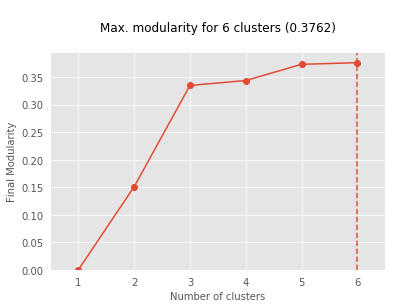

In [317]:
plot_max_modularities(modularities, rng)

In [291]:
g_g = np.dot(X.toarray(), X.toarray().T)

In [288]:
g_g.shape

(100, 100)

Genes - Genes

In [276]:
gg = np.zeros((df1.shape[0], df1.shape[0]))

In [281]:
t = np.array([
    [1,1,0,0,1,0,1],
    [1,0,1,0,0,0,1],
    [0,0,1,0,0,0,0],
    [1,1,0,0,1,0,0]
])

In [282]:
t

array([[1, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0]])

In [283]:
np.dot(t,t.T)

array([[4, 2, 0, 3],
       [2, 3, 1, 1],
       [0, 1, 1, 0],
       [3, 1, 0, 3]])

In [289]:
pd.DataFrame(np.dot(t,t.T))

,0,1,2,3
0,4,2,0,3
1,2,3,1,1
2,0,1,1,0
3,3,1,0,3


In [311]:
diag = 1 - np.diag((np.ones(g_g.shape[0])))

In [314]:
g_g = g_g * diag

## Genes - Genes

In [363]:
vec = CountVectorizer()
X = vec.fit_transform(genes_articles_str)

In [365]:
g_g = np.dot(X.toarray(), X.toarray().T)

In [367]:
diag = 1 - np.diag((np.ones(g_g.shape[0])))

In [368]:
g_g = g_g * diag

In [379]:
dt = g_g
model = CoclustMod(n_clusters=2, random_state=0)
m1 = model.fit(dt)
fit_data = dt[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

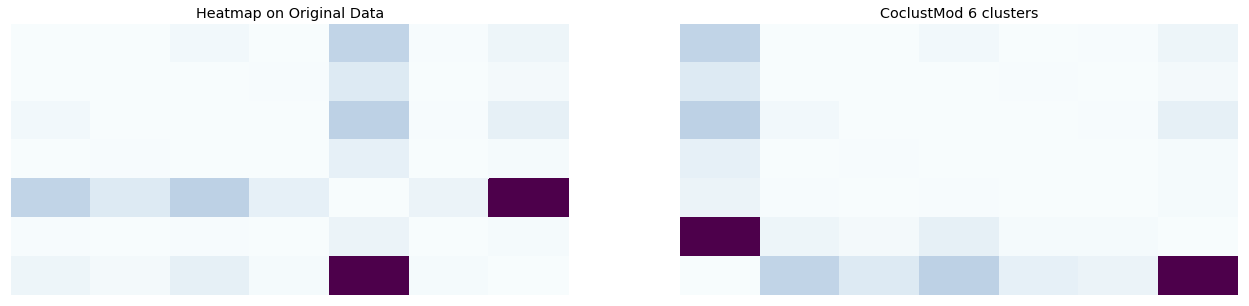

In [380]:
plt.figure(figsize=(22,5))

plt.subplot(121)
sns.heatmap(dt,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("Heatmap on Original Data")

plt.subplot(122)
sns.heatmap(fit_data,cmap="BuPu", yticklabels=False, xticklabels=False, cbar=False)
plt.title("CoclustMod %i clusters"%nb)


plt.show()

In [383]:
Z = linkage(g_g, 'single', 'euclidean')

/home/yannis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


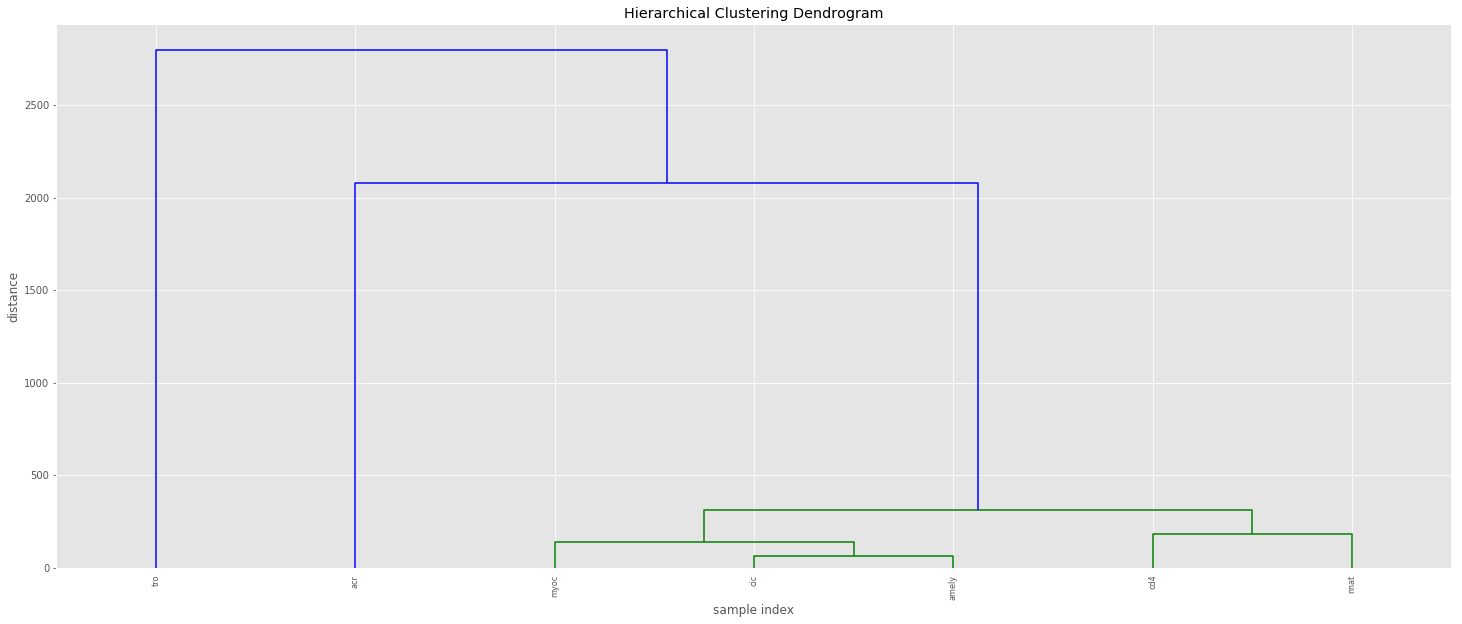

In [385]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = selected_genes
)
plt.show()

### CAH sur genes-articles 

In [102]:
Z = linkage(df3, 'single', 'hamming')

In [70]:
# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(
#     Z,
#     leaf_rotation=90.,  # rotates the x axis labels
#     leaf_font_size=8.,  # font size for the x axis labels
#     #labels = lb
# )
# plt.show()

In [25]:
from coclust.io.data_loading import load_doc_term_data
from coclust.visualization import (plot_reorganized_matrix,
                                  plot_cluster_top_terms,
                                  plot_max_modularities)
from coclust.evaluation.internal import best_modularity_partition
from coclust.coclustering import CoclustMod

In [324]:
clusters_range = range(2, 20)
model, modularities = best_modularity_partition(g_g, clusters_range, n_rand_init=1)

Computing coclust modularity for a range of cluster numbers =
 2 ...
 3 ...
 4 ...
 5 ...
 6 ...
 7 ...
 8 ...
 9 ...
 10 ...
 11 ...
 12 ...
 13 ...
 14 ...
 15 ...
 16 ...
 17 ...
 18 ...
 19 ...
 All done !


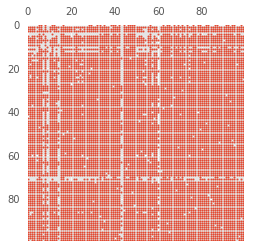

In [325]:
plot_reorganized_matrix(g_g, model)

In [ ]:
c, coph_dists = cophenet(Z, pdist(X, 'hamming'))

In [179]:
len(sg[0]["cd4"])

1211

In [172]:
np.count_nonzero(X.toarray()[0])

1211

In [79]:
m = maladiesjson[select_m[3]]

In [ ]:
g = [ ]

In [ ]:
list_idx = []

In [ ]:
sg = []
sg_list = []
lb = []
selected_genes = []
for k,g in genesjson.items():
    for i in g:
        if i in m:
            sg.append({k:g})
            lb.append(k)
            sg_list.append(' '.join(str(x) for x in g))
            selected_genes.append(k)
            break
    
    if len(sg) == 10:
        break

In [8]:
with open("progress.txt", 'r') as f:
        p = f.read()

In [9]:
p

''